# Optimization of a State-to-State Transfer in a Two-Level-System

The purpose
of this example is not to solve an especially interesting physical
problem but
to give a rather simple example of how the package can be used in
order to solve
an optimization probelm.

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
krotov      0.0.1
CPython 3.6.7
IPython 7.1.1


## Define the Hamiltonian

In the following the Hamiltonian, guess field and
states are defined.

The
Hamiltonian $H_{0} = - \omega \sigma_{z}$ represents a
simple qubit with energy
level splitting $\omega$ in the basis $\{|0\rangle,
|1\rangle\}$. The control
field $\epsilon(t)$ is assumed to couple via the
Hamiltonian $H_{1}(t) =
\epsilon(t) \sigma_{x}$ to the qubit, i.e., the control
field effectively drives
transitions between both qubit states. Here, for the
sake of simplicity, we
assume it to be constant.

In [2]:
def ham_and_states(omega=1.0, ampl0=0.1):
    """Two-level-system Hamiltonian"""
    H0 = qutip.Qobj(0.5*omega*np.diag([-1,1]))
    H1 = qutip.Qobj(np.mat([[1,2],[3,4]]))

    psi0 = qutip.Qobj(np.array([1,0]))
    psi1 = qutip.Qobj(np.array([0,1]))

    eps0 = lambda t, args: ampl0
    return ([H0, [H1, eps0]], psi0, psi1)

In [3]:
H, psi0, psi1 = ham_and_states()

The following projectors $P_0 = |0\rangle\langle0|$ and $P_1 =
|1\rangle\langle1|$ are introduced since they allow for calculating the
population in the respective states later on.

In [4]:
proj0 = psi0 * psi0.dag()
proj1 = psi1 * psi1.dag()

## Define the optimization target

First we define the time grid of the
dynamics, i.e., by taking the following
values as an example, we define the
initial state to be at time $t=0$ and
consider a total propagation time of
$T=5$. The entire time grid is divided into
$n_{t}=500$ equidistant time steps.

In [5]:
tlist = np.linspace(0, 5, 500)

In the next step we define the optimization targets, which is technically an
array, but here it has just one entry defining a simple state-to-state transfer
from initial state $|\Psi_{init}\rangle = |0\rangle$ to desired target state
$|\Psi_{trg}\rangle = |1\rangle$, which we want to reach at final time $T$. Note
that we also have to pass the Hamiltonian $H(t)$ that determines the dynamics of
the system to the optimization objectives.

In [6]:
objectives = [
    krotov.Objective(initial_state=psi0, target_state=psi1, H=H)
]

In addition, we have to define and assign a shape function $S(t)$ to each
control field that will be updated. This shape usually takes care of
experimental limits such as the necessity of finite ramps at the beginning and
end of the control field or other conceivable limitations for field shapes.
Moreover, from a technical perspective, special care must be taken when choosing
`lambda_a`. It controls the update magnitude of the respective field in each
iteration and must be chosen appropriately.

In [7]:
def S(t):
    """Shape function for the pulse update"""
    return 1.0

pulse_options = {
    H[1][1]: krotov.PulseOptions(lambda_a=5, shape=S)
}

def print_fidelity(**args):
    F_re = np.average(np.array(args['tau_vals']).real)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

## Simulate dynamics of the guess field

Before heading towards the optimization
procedure, we first simulate the
dynamics under the guess field
$\epsilon_{0}(t)$.

In [8]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $\epsilon_{0}(t)$, which is, as chosen
above, just a constant field.

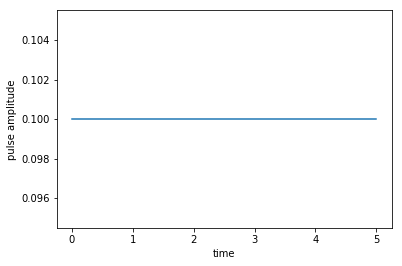

In [9]:
plot_pulse(H[1][1], tlist)

The next line solves the equation of motion for the defined objective, which
contains the initial state $|\Psi_{init}\rangle$ and the Hamiltonian $H(t)$
defining its evolution.

In [10]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

The plot of the population dynamics shows that the guess field does not transfer
the initial state $|\Psi_{init}\rangle = |0\rangle$ to the desired target state
$|\Psi_{trg}\rangle = |1\rangle$.

In [11]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

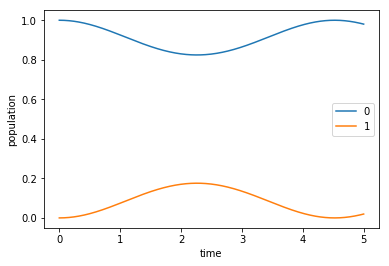

In [12]:
plot_population(guess_dynamics)

## Optimize

In the following we optimize the guess field $\epsilon_{0}(t)$ such
that the
intended state-to-state transfer $|\Psi_{init}\rangle \rightarrow
|\Psi_{trg}\rangle$ is solved.

In [13]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

The next line carries out the optimization. Therefore, it requires, besides the
previously defined optimization objectives `objectives`, information about the
optimization functional $F$ and the propagation method that should be used. In
addition, the number of total iterations is required and, as an option, we pass
the hook `print_fidelity` which prints out the value of the optimization
functional $F$ for each iterations.

Here, we choose $F = F_{re}$ with
\begin{equation}
F_{re}
= 1 - \mathrm{Re}\{\langle \Psi(T) | \Psi_{trg}
\rangle\}
\end{equation}

with
$|\Psi(T)\rangle$ the forward propagated state of
$|\Psi_{init}\rangle$.

In [14]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=5)

INFO:krotov:Initializing optimization with Krotov's method
INFO:krotov:Started initial forward propagation of objective 0
INFO:krotov:Finished initial forward propagation of objective 0
INFO:krotov:Started Krotov iteration 1
INFO:krotov:Started backward propagation of state 0


Iteration 0: 	F = 0.133400


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 1
INFO:krotov:Started Krotov iteration 2
INFO:krotov:Started backward propagation of state 0


Iteration 1: 	F = 0.800469


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 2
INFO:krotov:Started Krotov iteration 3
INFO:krotov:Started backward propagation of state 0


Iteration 2: 	F = 1.014176


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 3
INFO:krotov:Started Krotov iteration 4
INFO:krotov:Started backward propagation of state 0


Iteration 3: 	F = 1.116803


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 4
INFO:krotov:Started Krotov iteration 5
INFO:krotov:Started backward propagation of state 0


Iteration 4: 	F = 1.171907


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 5


Iteration 5: 	F = 1.200552


The following prints out information about the optimization procedure.

In [15]:
oct_result

Krotov Optimization Result
--------------------------
- Started at 2018-11-18 19:10:48
- Number of objectives: 1
- Number of iterations: 5
- Ended at 2018-11-18 19:10:55

In [16]:
logger.setLevel(logging.WARN)

## Simulate dynamics of the optimized field

After we obtained the optimized
control field in the previous steps, we can now
plot it and calculate the
population dynamics under this field.

The optimized field ranges from negative
to positive values and has no
particular shape.

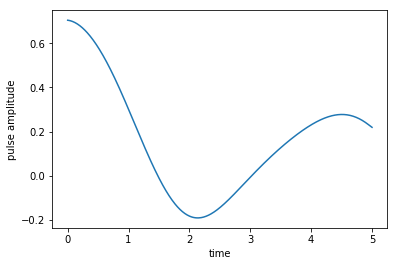

In [17]:
plot_pulse(oct_result.optimized_controls[0], tlist)

In contrast to the dynamics under the guess field, the optimized field indeed
drives the initial state $|\Psi_{init}\rangle = |0\rangle$ to the desired target
state $|\Psi_{trg}\rangle = |1\rangle$.

In [18]:
opt_dynamics = oct_result.optimized_objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

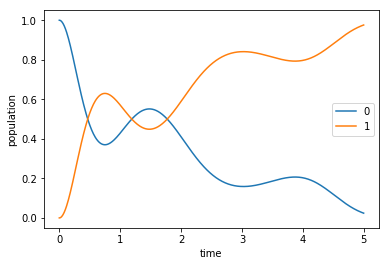

In [19]:
plot_population(opt_dynamics)